In [65]:
# Setup
import pandas as pd
import toytree as tt
import numpy as np
import arviz as az
import anndata as ad
import os
import pickle as pkl
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [66]:
plot_path = "./plots/"

def get_scores(df, add=""):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df[f"tp{add}"].astype("float64")
    tn = df[f"tn{add}"].astype("float64")
    fp = df[f"fp{add}"].astype("float64")
    fn = df[f"fn{add}"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df[f"tpr{add}"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df[f"tnr{add}"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df[f"precision{add}"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df[f"fdr{add}"] = fdr
    acc = ((tp + tn) / (tp + tn + fp + fn)).fillna(0)
    df[f"accuracy{add}"] = acc

    df[f"youden{add}"] = tpr + tnr - 1
    df[f"f1_score{add}"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df[f"mcc{add}"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df


def classify(row):
    p = row["num_otus"]

    gt = np.zeros(p)
    gt2 = np.zeros(p)

    if type(row["effect_otus"]) == str:
        eff = eval(row["effect_otus"].replace("[ ", "[").replace("  ", " ").replace(" ", ", "))
    else:
        eff = row["effect_otus"]
    gt[eff] = 1

    gt2[np.arange(13, 24, 1)] = 1


    pred = np.zeros(p)
    pred_2 = np.zeros(p)

    res = [int(x) for x in eval(row["result_otus"])]
    pred[[x for x in res if x < p]] = 1
    pred_2[[x-p for x in res if x >= p and x < 2*p]] = 1
    pred_3 = [x-2*p for x in res if x >= 2*p]

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(gt2, pred_2).ravel()
    tn3 = p-len(pred_3)
    fp3 = len(pred_3)
    fn3 = 0
    tp3 = 0
    return tp, tn, fp, fn, tp2, tn2, fn2, fp2, tn3, fp3, fn3, tp3

In [67]:
tree_agg_path = results_path = "./results3/"

tree_agg_res = []

for f in os.listdir(tree_agg_path):
    if f.startswith("result_df"):
        tree_agg_res.append(pd.read_csv(tree_agg_path + f, index_col=0))

tree_agg_df = pd.concat(tree_agg_res)
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,num_otus,dataset_id
0,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3436.367443,0.88330,10,0.9,30,70
1,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3471.870087,0.00000,10,0.9,30,71
2,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3449.567294,0.85975,10,0.9,30,72
3,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3362.198744,0.85965,10,0.9,30,73
4,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3514.670527,0.87920,10,0.9,30,74
...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,0.0,[],[],-3456.975284,0.87640,10,0.3,30,5
6,tree_agg,new_3,NaN,0.0,[],[],-3528.193874,0.85110,10,0.3,30,6
7,tree_agg,new_3,NaN,0.0,[],[],-3428.443173,0.85545,10,0.3,30,7
8,tree_agg,new_3,NaN,0.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3404.177418,0.85815,10,0.3,30,8


In [82]:
ground_truth = {
    30: ([39], np.arange(0, 27))
}

tree_agg_df["effect_nodes"] = [ground_truth[x][0] for x in tree_agg_df["num_otus"]]
tree_agg_df["effect_otus"] = [ground_truth[x][1] for x in tree_agg_df["num_otus"]]
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,...,tpr3,tnr3,precision3,fdr3,accuracy3,youden3,f1_score3,mcc3,num_effects,hamming
0,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3436.367443,0.88330,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
1,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3471.870087,0.00000,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
2,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3449.567294,0.85975,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
3,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3362.198744,0.85965,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
4,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3514.670527,0.87920,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,0.0,[],[],-3456.975284,0.87640,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
6,tree_agg,new_3,NaN,0.0,[],[],-3528.193874,0.85110,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
7,tree_agg,new_3,NaN,0.0,[],[],-3428.443173,0.85545,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
8,tree_agg,new_3,NaN,0.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3404.177418,0.85815,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16


In [83]:
classes = tree_agg_df.apply(classify, axis=1)

tree_agg_df["tp"] = [x[0] for x in classes]
tree_agg_df["tn"] = [x[1] for x in classes]
tree_agg_df["fp"] = [x[2] for x in classes]
tree_agg_df["fn"] = [x[3] for x in classes]
tree_agg_df["tp2"] = [x[4] for x in classes]
tree_agg_df["tn2"] = [x[5] for x in classes]
tree_agg_df["fp2"] = [x[6] for x in classes]
tree_agg_df["fn2"] = [x[7] for x in classes]
tree_agg_df["tp3"] = [x[8] for x in classes]
tree_agg_df["tn3"] = [x[9] for x in classes]
tree_agg_df["fp3"] = [x[10] for x in classes]
tree_agg_df["fn3"] = [x[11] for x in classes]
tree_agg_df = get_scores(tree_agg_df)
tree_agg_df = get_scores(tree_agg_df, add="2")
tree_agg_df = get_scores(tree_agg_df, add="3")
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,...,tpr3,tnr3,precision3,fdr3,accuracy3,youden3,f1_score3,mcc3,num_effects,hamming
0,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3436.367443,0.88330,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
1,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3471.870087,0.00000,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
2,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3449.567294,0.85975,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
3,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3362.198744,0.85965,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
4,tree_agg,new_3,NaN,-10.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3514.670527,0.87920,10,0.9,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,0.0,[],[],-3456.975284,0.87640,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
6,tree_agg,new_3,NaN,0.0,[],[],-3528.193874,0.85110,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
7,tree_agg,new_3,NaN,0.0,[],[],-3428.443173,0.85545,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.001,11
8,tree_agg,new_3,NaN,0.0,['39'],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3404.177418,0.85815,10,0.3,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.001,16


In [84]:
def get_num_eff(row):
    if row["model"] in ["tree_agg", "adaANCOM"]:
        return len([int(x) for x in eval(row["result_nodes"])])
    else:
        return len([int(x) for x in eval(row["result_otus"])])

num_eff =  classes = tree_agg_df.apply(get_num_eff, axis=1)
tree_agg_df["num_effects"] = num_eff + 0.001
tree_agg_df["hamming"] = tree_agg_df["fn"] + tree_agg_df["fp"]


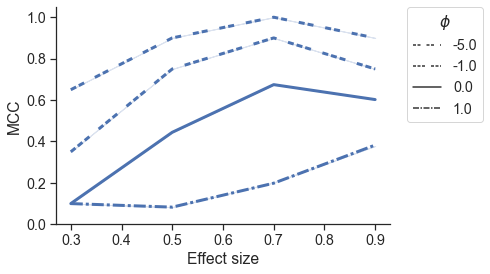

In [111]:
sns.set(style="ticks", font_scale=1.3)

g = sns.lineplot(data=tree_agg_df[tree_agg_df["phi"].isin([-5, -1, 0, 1])], x="effect_size", y="mcc",
                 palette="tab10",
                 style="phi",
                 legend=True,
                 ci=False,
                 lw=3,
                 dashes=[(2,1,2,4), (2,1,2,1,2,4), "", (4,1,1,1)]
            )
g.set(ylim=[0, 1.05])
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=r"$\phi$")
plt.xlabel("Effect size")
plt.ylabel("MCC")

plt.savefig(plot_path + "high_effect_mcc_v2.svg", bbox_inches="tight", format="svg")

plt.show()


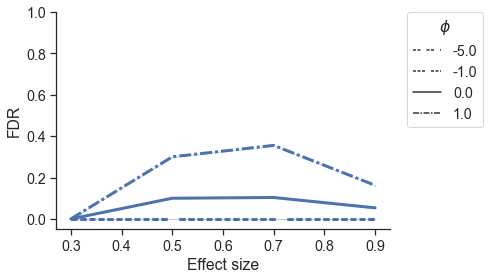

In [112]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["phi"].isin([-5, -1, 0, 1])], x="effect_size", y="fdr",
                 palette="tab10",
                 style="phi",
                 legend=True,
                 ci=False,
                 lw=3,
                 dashes=[(2,1,2,4), (2,1,2,1,2,4), "", (4,1,1,1)]
                 )
g.set(ylim=[-0.05, 1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=r"$\phi$")

plt.xlabel("Effect size")
plt.ylabel("FDR")
sns.despine()
plt.savefig(plot_path + "high_effect_fdr_v2.svg", bbox_inches="tight", format="svg")
plt.show()

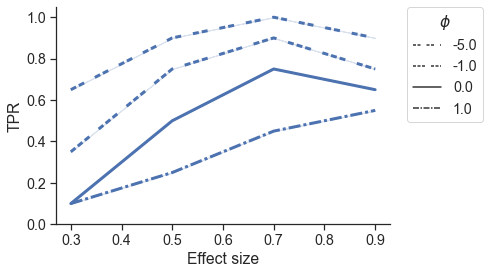

In [113]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["phi"].isin([-5, -1, 0, 1])], x="effect_size", y="tpr",
                 palette="tab10",
                 style="phi",
                 legend=True,
                 ci=False,
                  lw=3,
                 dashes=[(2,1,2,4), (2,1,2,1,2,4), "", (4,1,1,1)]
            )
g.set(ylim=[0,1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=r"$\phi$")
g.set(ylim=[0,1.05])

plt.xlabel("Effect size")
plt.ylabel("TPR")
sns.despine()
plt.savefig(plot_path + "high_effect_tpr_v2.svg", bbox_inches="tight", format="svg")
plt.show()

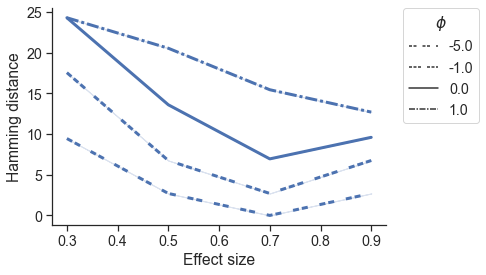

In [114]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["phi"].isin([-5, -1, 0, 1])], x="effect_size", y="hamming",
                 palette="tab10",
                 style="phi",
                 legend=True,
                 ci=False,
                lw=3,
                 dashes=[(2,1,2,4), (2,1,2,1,2,4), "", (4,1,1,1)]
            )


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=r"$\phi$")

# (g.set_axis_labels("Replicates per group", "TPR").tight_layout(w_pad=0))

plt.ylabel("Hamming distance")
plt.xlabel("Effect size")
sns.despine()
plt.savefig(plot_path + "high_effect_hamming_v2.svg", bbox_inches="tight", format="svg")
plt.show()

In [102]:
print(tree_agg_df.loc[
          (tree_agg_df["phi"] == 5)&
          (tree_agg_df["effect_size"] == 0.9),
    ["reg_method", "effect_size", "phi", "result_nodes", "result_otus", "dataset_id", "mcc"]
      ])

  reg_method  effect_size  phi  \
0      new_3          0.9  5.0   
1      new_3          0.9  5.0   
2      new_3          0.9  5.0   
3      new_3          0.9  5.0   
4      new_3          0.9  5.0   
5      new_3          0.9  5.0   
6      new_3          0.9  5.0   
7      new_3          0.9  5.0   
8      new_3          0.9  5.0   
9      new_3          0.9  5.0   
0      new_3          0.9  5.0   
1      new_3          0.9  5.0   
2      new_3          0.9  5.0   
3      new_3          0.9  5.0   
4      new_3          0.9  5.0   
5      new_3          0.9  5.0   
6      new_3          0.9  5.0   
7      new_3          0.9  5.0   
8      new_3          0.9  5.0   
9      new_3          0.9  5.0   

                                        result_nodes  \
0  ['27', '19', '21', '24', '26', '30', '31', '32...   
1  ['28', '14', '17', '19', '24', '30', '31', '32...   
2                                             ['27']   
3                                  ['27', '23', '5']   
4    